<a href="https://colab.research.google.com/github/CassieHuang22/CIS581-Final-Project-Masked-Facial-Recognition/blob/main/facial_recognition_unmasked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training on Unmasked Faces

This notebook trains our model for our dataset of unmasked faces and creates graphs of our training results.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/CIS5810/Final Project/Model Weights

/content/drive/MyDrive/CIS5810/Final Project/Model Weights


In [ ]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.1 MB/s 


In [ ]:
import torchvision
import torch
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

In [ ]:
train_transforms = transforms.Compose([transforms.Resize((160, 160)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
test_transforms = transforms.Compose([transforms.Resize((160, 160)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

In [ ]:
lfw_train = torchvision.datasets.LFWPairs(".", split='train', download=True, transform=train_transforms)
lfw_test = torchvision.datasets.LFWPairs(".", split='test', download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Training

In [ ]:
from facenet_pytorch import InceptionResnetV1

In [ ]:
class face_rec(torch.nn.Module):
  def __init__(self):
    super().__init__()
    #self.resnet_18 = torchvision.models.resnet18()
    self.inception_resnet = InceptionResnetV1(pretrained='vggface2').eval()
    self.fc_layers = torch.nn.Sequential(torch.nn.Linear(512, 1), torch.nn.Sigmoid())

  def forward(self, img1, img2):
    encoding_1 = self.inception_resnet(img1)
    encoding_2 = self.inception_resnet(img2)
    input_fc = torch.abs(encoding_1 - encoding_2)
    out = self.fc_layers(input_fc)
    return out

In [ ]:
trainloader = torch.utils.data.DataLoader(lfw_train, batch_size=16,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(lfw_test, batch_size=16)

In [ ]:
N = len(lfw_train)
val_N = len(lfw_test)
N, val_N

(2200, 1000)

In [ ]:
lr = 1e-3
weight_decay = 75e-4

In [ ]:
def train_model(face_model, criterion, optimizer, trainloader, testloader, epochs):
  train_losses = []
  validation_losses = []
  validation_errors = []
  epochs_list = []
  net = face_model.to(device)
  best_val_accuracy = 0
  # Freeze model inception_resnet parameters
  for param in net.inception_resnet.parameters():
    param.requires_grad = False
  for epoch in range(epochs):
    epoch_loss = 0.0
    flag = 0
    if epoch == 20 and flag == 0:
      for op_params in optimizer.param_groups:
        op_params['lr'] = 1e-3
      flag = 1
    net.train()
    for i, (img1, img2, labels) in enumerate(trainloader):
      images1 = img1.to(device)
      images2 = img2.to(device)
      labels = labels.to(device)
      outputs = net(images1, images2)
      loss = criterion(torch.flatten(outputs), labels.float())
      optimizer.zero_grad()
      loss.backward()
      epoch_loss += loss.item() * images1.shape[0]
      optimizer.step()
      #if ((i+1) % 20 == 0):
      #  print("Epoch: " + str(epoch + 1) + ", Step: " + str(i+1) + ", Loss = " + str(loss.item()))
    net.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      val_loss = 0
      for test_img1, test_img2, labels in testloader:
        test_images1 = test_img1.to(device)
        test_images2 = test_img2.to(device)
        labels = labels.to(device)
        outputs = net(test_images1, test_images2)
        val_loss += criterion(torch.flatten(outputs), labels.float()).item() * test_images1.shape[0]
        predictions = torch.flatten(torch.tensor(outputs.clone().detach() > 0.5, dtype=int))
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    val_accuracy = correct / total
    train_losses.append(epoch_loss / N)
    validation_losses.append(val_loss / val_N)
    validation_errors.append(1 - val_accuracy)
    epochs_list.append(epoch)
    if(((epoch + 1) > epochs // 3) and (val_accuracy > best_val_accuracy)):
      best_val_accuracy = val_accuracy
      file_name = "weights_lr"+str(lr)+"_wd"+str(weight_decay)+"_epoch"+str(epochs)
      torch.save(net.state_dict(), file_name)
    print("Epoch: " + str(epoch + 1) + ", Epoch-loss: " + str(epoch_loss / N) + ", Accuracy-test: " + str(val_accuracy))
  
  return train_losses, validation_losses, validation_errors, epochs_list

In [ ]:
facenet = face_rec()
optimizer = torch.optim.Adam(facenet.parameters(), lr=lr, weight_decay=weight_decay)
criterion = torch.nn.BCELoss()

In [ ]:
train_losses, validation_losses, validation_errors, epochs_list = train_model(facenet, criterion, optimizer, trainloader, testloader, 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 1, Epoch-loss: 0.6855048287998546, Accuracy-test: 0.5
Epoch: 2, Epoch-loss: 0.6800647258758545, Accuracy-test: 0.505
Epoch: 3, Epoch-loss: 0.6765254592895508, Accuracy-test: 0.525
Epoch: 4, Epoch-loss: 0.6736337902329185, Accuracy-test: 0.585
Epoch: 5, Epoch-loss: 0.6703681553493847, Accuracy-test: 0.752
Epoch: 6, Epoch-loss: 0.6675692731683904, Accuracy-test: 0.742
Epoch: 7, Epoch-loss: 0.6642767043547196, Accuracy-test: 0.722
Epoch: 8, Epoch-loss: 0.6617537294734608, Accuracy-test: 0.844
Epoch: 9, Epoch-loss: 0.6588306561383334, Accuracy-test: 0.757
Epoch: 10, Epoch-loss: 0.6561406005512584, Accuracy-test: 0.784
Epoch: 11, Epoch-loss: 0.6542038453708996, Accuracy-test: 0.77
Epoch: 12, Epoch-loss: 0.6528457403182983, Accuracy-test: 0.754
Epoch: 13, Epoch-loss: 0.6506830607761036, Accuracy-test: 0.849
Epoch: 14, Epoch-loss: 0.6471544924649325, Accuracy-test: 0.857
Epoch: 15, Epoch-loss: 0.6428714080290361, Accuracy-test: 0.917
Epoch: 16, Epoch-loss: 0.644547032659704, Accuracy-t

## Evaluation

In [ ]:
best_model = face_rec().to(device)
best_model.load_state_dict(torch.load("/content/drive/MyDrive/CIS5810/Final Project/Model Weights/weights_lr0.001_wd0.0075_epoch20"))
best_model.eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

face_rec(
  (inception_resnet): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=

In [ ]:
def evaluate_model(net):
  with torch.no_grad():
      correct = 0
      total = 0
      val_loss = 0
      for test_img1, test_img2, labels in testloader:
        test_images1 = test_img1.to(device)
        test_images2 = test_img2.to(device)
        labels = labels.to(device)
        outputs = net(test_images1, test_images2)
        val_loss += criterion(torch.flatten(outputs), labels.float()).item() * test_images1.shape[0]
        predictions = torch.flatten(torch.tensor(outputs.clone().detach() > 0.5, dtype=int))
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
  return correct / total

In [ ]:
print("Best accuracy:", evaluate_model(best_model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Best accuracy: 0.917


## Training Plots
The code below creates plots of our results for training.

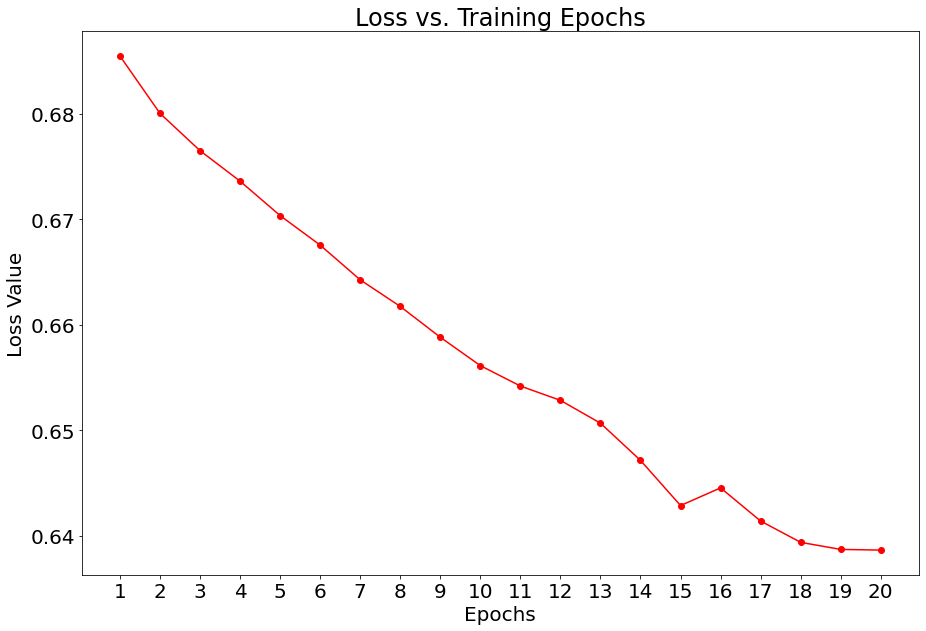

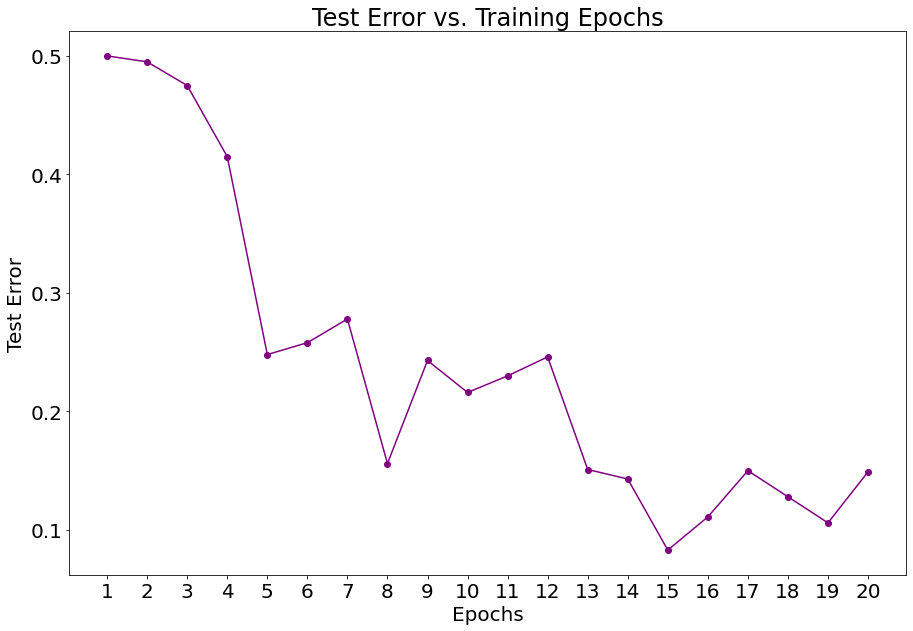

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams.update({'font.size': 20})

losses = [0.6855048287998546, 0.6800647258758545, 0.6765254592895508, 0.6736337902329185, 0.6703681553493847, 0.6675692731683904, 0.6642767043547196, 0.6617537294734608, 0.6588306561383334, 0.6561406005512584, 0.6542038453708996, 0.6528457403182983, 0.6506830607761036, 0.6471544924649325, 0.6428714080290361, 0.644547032659704, 0.6414007238908247, 0.6393819427490235, 0.6387099825252186, 0.6386470456556841]
epochs = list(range(1, 21))
plt.figure(figsize=(15, 10))
plt.scatter(epochs, losses, color='red')
plt.plot(epochs, losses, color='red')
plt.xticks(range(1, 21))
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Loss vs. Training Epochs")

plt.show()

accuracy = [0.5, 0.505, 0.525, 0.585, 0.752, 0.742, 0.722, 0.844, 0.757, 0.784, 0.77, 0.754, 0.849, 0.857, 0.917, 0.889, 0.85, 0.872, 0.894, 0.851]
epochs = list(range(1, 21))
plt.figure(figsize=(15, 10))
plt.scatter(epochs, 1-np.array(accuracy), color='purple')
plt.plot(epochs, 1-np.array(accuracy), color='purple')
plt.xticks(range(1, 21))
plt.xlabel("Epochs")
plt.ylabel("Test Error")
plt.title("Test Error vs. Training Epochs")

plt.show()